# Waymo Open Dataset E2ED Visualization

This notebook visualizes all camera images, ego vehicle intent, sequence number, and index number from the Waymo Open Dataset End-to-End Driving (E2ED) data. It also projects past trajectory states onto back cameras (side_left, side_right, rear, rear_left, rear_right) and future states onto front cameras (front, front_left, front_right). Additionally, it stitches front and back camera images into a top-down (bird's-eye) view with trajectories overlaid.

**Dataset Details**:
- Visualizes all cameras: front (1), front_left (2), front_right (3), side_left (4), side_right (5), rear_left (6), rear (7), rear_right (8).
- Past states (t = -4s to 0s) are shown on back cameras; future states (t = 0s to 5s) on front cameras.
- Stitched top-down view combines all cameras into a vehicle-centric bird's-eye perspective.

## Package Installation

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

2025-04-24 23:03:21.908850: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 23:03:21.910319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:03:21.940107: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:03:21.940817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 23:03:23.412650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Loading the Data

In [2]:
# Set environment variables for authentication
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token1.json'

# Define dataset path
DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'
TRAIN_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')

# Initialize dataset
filenames = tf.io.matching_files(TRAIN_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()

# Retrieve one example (targeting the specified frame)
target_frame_name = 'b197472f28df9f18c22654a5b514082a-072'
data = None
for bytes_example in dataset_iter:
    frame_data = wod_e2ed_pb2.E2EDFrame()
    frame_data.ParseFromString(bytes_example)
    print(frame_data.frame.context.name)
    if frame_data.frame.context.name == target_frame_name:
        data = frame_data
        break

2025-04-24 23:03:36.582241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-24 23:03:36.582713: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-24 23:03:37.920207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

d6cdf6eb1b7d4a8be6dac71f34e6cdb7-164
b197472f28df9f18c22654a5b514082a-072


## Visualization Functions

In [4]:
def get_all_cameras(data: wod_e2ed_pb2.E2EDFrame):
    """Return all 8 camera images and calibrations."""
    image_list = []
    calibration_list = []
    camera_names = {
        1: 'FRONT',
        2: 'FRONT_LEFT',
        3: 'FRONT_RIGHT',
        4: 'SIDE_LEFT',
        5: 'SIDE_RIGHT',
        6: 'REAR_LEFT',
        7: 'REAR',
        8: 'REAR_RIGHT'
    }
    order = [1, 2, 3, 4, 5, 6, 7, 8]
    
    for camera_name in order:
        for index, image_content in enumerate(data.frame.images):
            if image_content.name == camera_name:
                calibration = data.frame.context.camera_calibrations[index]
                image = tf.io.decode_image(image_content.image).numpy()
                image_list.append((camera_names[camera_name], image))
                calibration_list.append((camera_names[camera_name], calibration))
                break
    
    return image_list, calibration_list

def project_vehicle_to_image(vehicle_pose, calibration, points):
    """Projects from vehicle coordinate system to image with global shutter."""
    pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
    world_points = np.zeros_like(points)
    for i, point in enumerate(points):
        cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
        world_points[i] = (cx, cy, cz)

    extrinsic = tf.reshape(
        tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32), [4, 4])
    intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
    metadata = tf.constant([
        calibration.width,
        calibration.height,
        open_dataset.CameraCalibration.GLOBAL_SHUTTER,
    ], dtype=tf.int32)
    camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

    return py_camera_model_ops.world_to_image(
        extrinsic, intrinsic, metadata, camera_image_metadata, world_points).numpy()

def draw_points_on_image(image, points, size, color=(255, 0, 0)):
    """Draws points on an image."""
    image_copy = image.copy()
    for point in points:
        if point[2] > 0:  # Check if point is valid (ok flag)
            cv2.circle(image_copy, (int(point[0]), int(point[1])), size, color, -1)
    return image_copy

def create_top_down_view(images, calibrations, past_waypoints, future_waypoints, vehicle_pose, resolution=0.1, view_size=100):
    """
    Project camera images into a top-down (bird's-eye) view and overlay trajectories.
    - resolution: meters per pixel
    - view_size: size of the view in meters (square view: view_size x view_size)
    """
    canvas_size = int(view_size / resolution)
    canvas = np.zeros((canvas_size, canvas_size, 3), dtype=np.uint8)
    center = canvas_size // 2
    
    for (camera_name, image), (_, calibration) in zip(images, calibrations):
        h, w = image.shape[:2]
        u, v = np.meshgrid(np.arange(w), np.arange(h))
        uv = np.stack([u, v, np.ones_like(u)], axis=-1).reshape(-1, 3)
        
        extrinsic = np.array(calibration.extrinsic.transform).reshape(4, 4)
        intrinsic = np.array(calibration.intrinsic)
        fx, fy, cx, cy = intrinsic[:4]
        K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        K_inv = np.linalg.inv(K)
        R = extrinsic[:3, :3]
        t = extrinsic[:3, 3]
        
        rays = (K_inv @ uv.T).T
        rays = rays / rays[:, 2:3]
        world_points = np.zeros((len(rays), 3))
        for i, ray in enumerate(rays):
            ray_dir = np.linalg.inv(R) @ ray
            if abs(ray_dir[2]) < 1e-5:
                continue
            s = -t[2] / ray_dir[2]
            if s <= 0:
                continue
            point = t + s * ray_dir
            world_points[i] = point
        
        valid = (np.abs(world_points[:, 0]) < view_size/2) & (np.abs(world_points[:, 1]) < view_size/2)
        world_points = world_points[valid]
        uv = uv[valid][:, :2]
        
        canvas_x = (world_points[:, 0] / resolution + center).astype(int)
        canvas_y = (-world_points[:, 1] / resolution + center).astype(int)
        valid = (canvas_x >= 0) & (canvas_x < canvas_size) & (canvas_y >= 0) & (canvas_y < canvas_size)
        canvas_x, canvas_y = canvas_x[valid], canvas_y[valid]
        uv = uv[valid]
        
        for (px, py), (u, v) in zip(zip(canvas_x, canvas_y), uv.astype(int)):
            canvas[py, px] = image[v, u]
    
    past_canvas_points = ((past_waypoints[:, :2] / resolution) + center).astype(int)
    future_canvas_points = ((future_waypoints[:, :2] / resolution) + center).astype(int)
    
    for pt in past_canvas_points:
        x, y = pt[0], -pt[1] + 2*center
        if 0 <= x < canvas_size and 0 <= y < canvas_size:
            cv2.circle(canvas, (x, y), 15, (0, 255, 0), -1)
    for pt in future_canvas_points:
        x, y = pt[0], -pt[1] + 2*center
        if 0 <= x < canvas_size and 0 <= y < canvas_size:
            cv2.circle(canvas, (x, y), 15, (255, 0, 0), -1)
    
    return canvas

## Visualize All Cameras with Trajectories and Metadata

ValueError: num must be 1 <= num <= 8, not 9

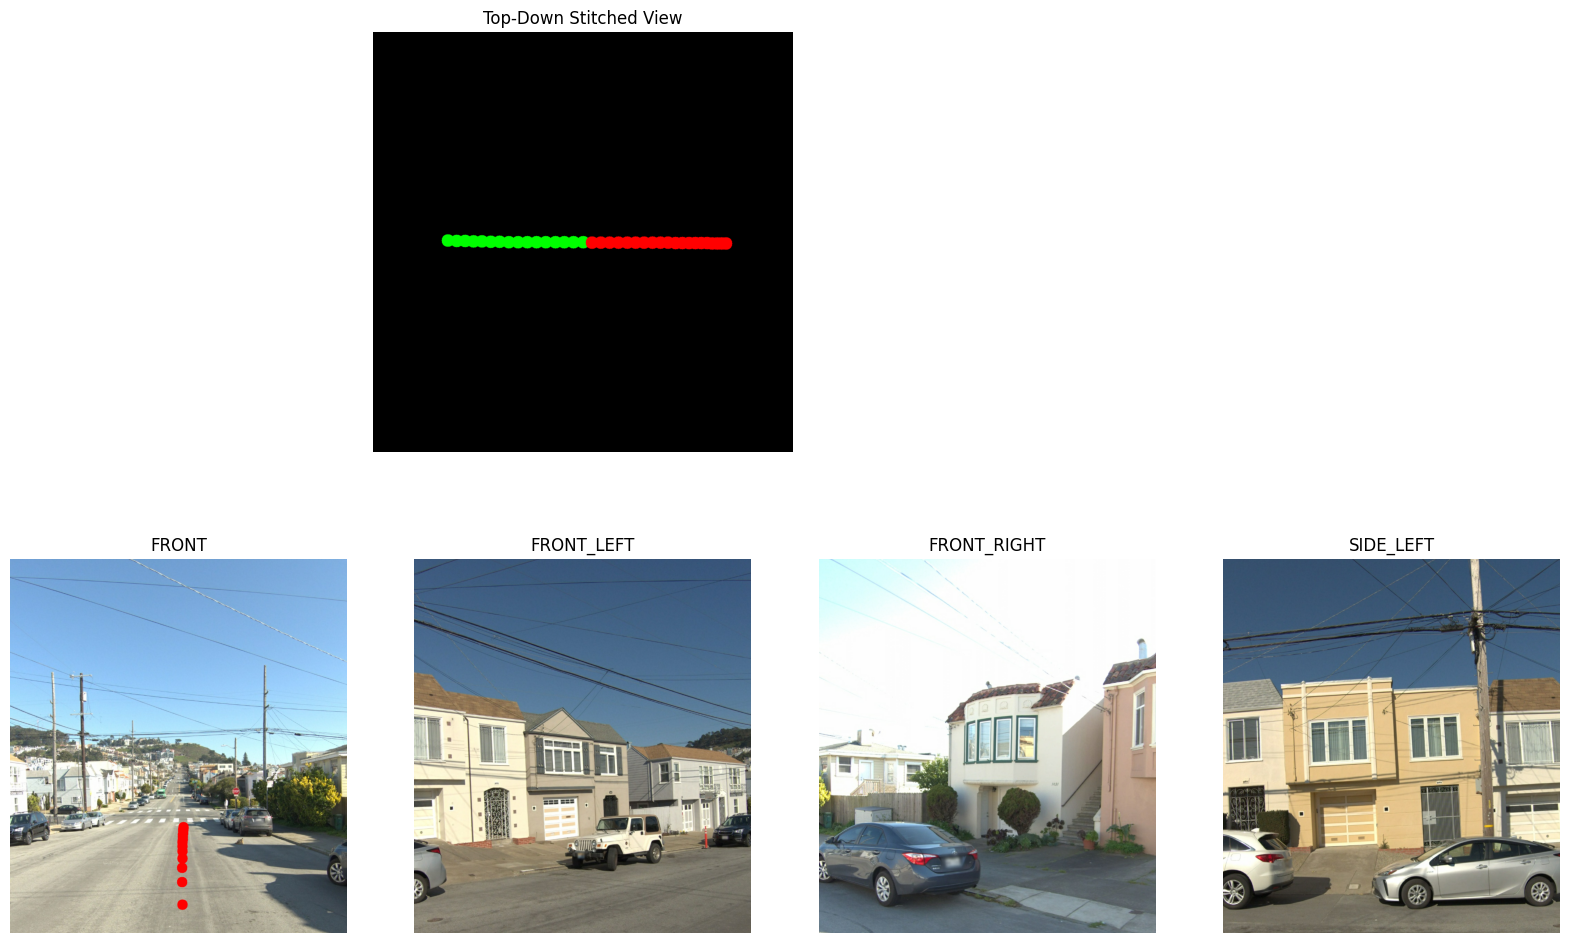

In [5]:
all_camera_images, all_camera_calibrations = get_all_cameras(data)

# Extract past and future trajectories
past_waypoints = np.stack([data.past_states.pos_x, data.past_states.pos_y, np.zeros_like(data.past_states.pos_x)], axis=1)
future_waypoints = np.stack([data.future_states.pos_x, data.future_states.pos_y, data.future_states.pos_z], axis=1)

# Get vehicle pose
vehicle_pose = data.frame.images[0].pose

# Prepare individual camera images with trajectories
images_with_points = []
camera_names = [name for name, _ in all_camera_images]
for i, (camera_name, image) in enumerate(all_camera_images):
    calibration = next(calib for name, calib in all_camera_calibrations if name == camera_name)
    if camera_name in ['SIDE_LEFT', 'SIDE_RIGHT', 'REAR', 'REAR_LEFT', 'REAR_RIGHT']:
        waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, past_waypoints)
        image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(0, 255, 0))
    elif camera_name in ['FRONT', 'FRONT_LEFT', 'FRONT_RIGHT']:
        waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, future_waypoints)
        image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(255, 0, 0))
    else:
        image_with_points = image.copy()
    images_with_points.append((camera_name, image_with_points))

# Create top-down stitched view
top_down_image = create_top_down_view(all_camera_images, all_camera_calibrations, past_waypoints, future_waypoints, vehicle_pose)

# Extract metadata
frame_name = data.frame.context.name
uuid, seq_num = frame_name.rsplit('-', 1)
seq_num = int(seq_num)
intent = wod_e2ed_pb2.EgoIntent.Intent.Name(data.intent)
index_num = seq_num

# Visualize
fig = plt.figure(figsize=(20, 12))
axes = fig.add_subplot(2, 4, (1, 3))
axes.imshow(top_down_image)
axes.set_title('Top-Down Stitched View')
axes.axis('off')

for i, (camera_name, image) in enumerate(images_with_points):
    ax = fig.add_subplot(2, 4, i+5)
    ax.imshow(image)
    ax.set_title(camera_name)
    ax.axis('off')

plt.suptitle(f'Frame: {frame_name}\nUUID: {uuid}\nSeqNum: {seq_num}\nIndex: {index_num}\nIntent: {intent}', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()